## Bayesian AGN Decomposition Analysis for SDSS Spectra (BADASS)
### Example: LVS Rodeo Cube Example

This example showcases how to fit a general IFU cube.  The data is a subcube of a much larger MUSE cube of NGC 1386.  The data and fitting was showcased at [Large-Volume Spectroscopic Analyses of AGN and Star Forming Galaxies in the Era of JWST](https://www.stsci.edu/contents/events/stsci/2022/march/large-volume-spectroscopic-analyses-of-agn-and-star-forming-galaxies-in-the-era-of-jwst) workshop at STScI.

####  Remington O. Sexton$^{1}$, Sara M. Doan$^{2}$, William Matzko$^{2}$ Michael A. Reefe$^{2}$, 
$^{1}$United States Naval Observatory, $^{2}$George Mason University

In [1]:
import glob
import time
import natsort
from IPython.display import clear_output
import os
import sys
import psutil
import pathlib
import natsort
# Import BADASS here
BADASS_DIR = pathlib.Path(os.getcwd()).resolve().parent
sys.path.insert(1,str(BADASS_DIR))
import badass as badass
import badass_check_input
import badass_ifu as ifu

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

### BADASS Options

In [2]:
################################## Fit Options #################################
# Fitting Parameters
fit_options={
"fit_reg"    : (4800,5200),# Fitting region; Note: Indo-US Library=(3460,9464)
"good_thresh": 0.0, # percentage of "good" pixels required in fig_reg for fit.
"mask_bad_pix": False, # mask pixels SDSS flagged as 'bad' (careful!)
"mask_emline" : False, # automatically mask lines for continuum fitting.
"mask_metal": False, # interpolate over metal absorption lines for high-z spectra
"fit_stat": "ML", # fit statistic; ML = Max. Like. , OLS = Ordinary Least Squares
"n_basinhop": 10, # Number of consecutive basinhopping thresholds before solution achieved
"test_lines": False, # Perform line/configuration testing for multiple components
"max_like_niter": 0, # number of maximum likelihood iterations
"output_pars": False, # only output free parameters of fit and stop code (diagnostic)
"cosmology": {"H0":70.0, "Om0": 0.30}, # Flat Lam-CDM Cosmology
}
################################################################################

########################### MCMC algorithm parameters ##########################
mcmc_options={
"mcmc_fit"    : False, # Perform robust fitting using emcee
"nwalkers"    : 100,  # Number of emcee walkers; min = 2 x N_parameters
"auto_stop"   : False, # Automatic stop using autocorrelation analysis
"conv_type"   : "all", # "median", "mean", "all", or (tuple) of parameters
"min_samp"    : 1000,  # min number of iterations for sampling post-convergence
"ncor_times"  : 10.0,  # number of autocorrelation times for convergence
"autocorr_tol": 10.0,  # percent tolerance between checking autocorr. times
"write_iter"  : 100,   # write/check autocorrelation times interval
"write_thresh": 100,   # iteration to start writing/checking parameters
"burn_in"     : 1500, # burn-in if max_iter is reached
"min_iter"    : 1000, # min number of iterations before stopping
"max_iter"    : 2500, # max number of MCMC iterations
}
################################################################################

############################ Fit component op dtions #############################
comp_options={
"fit_opt_feii"     : False, # optical FeII
"fit_uv_iron"      : False, # UV Iron 
"fit_balmer"       : False, # Balmer continuum (<4000 A)
"fit_losvd"        : False, # stellar LOSVD
"fit_host"         : True, # host template
"fit_power"        : True, # AGN power-law
"fit_poly"         : True, # Add polynomial continuum component
"fit_narrow"       : True, # narrow lines
"fit_broad"        : False, # broad lines
"fit_absorp"       : False, # absorption lines
"tie_line_disp"    : False, # tie line widths (dispersions)
"tie_line_voff"    : False, # tie line velocity offsets
}

# Line options for each narrow, broad, and absorption.
narrow_options = {
#     "amp_plim": (0,1), # line amplitude parameter limits; default (0,)
    "disp_plim": (0,500), # line dispersion parameter limits; default (0,)
    "voff_plim": (-500,500), # line velocity offset parameter limits; default (0,)
    "line_profile": "gaussian", # line profile shape*
    "n_moments": 4, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)
}

broad_options ={
#     "amp_plim": (0,40), # line amplitude parameter limits; default (0,)
    "disp_plim": (500,3000), # line dispersion parameter limits; default (0,)
    "voff_plim": (-1000,1000), # line velocity offset parameter limits; default (0,)
    "line_profile": "voigt", # line profile shape*
    "n_moments": 4, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)
}

absorp_options = {
#     "amp_plim": (-1,0), # line amplitude parameter limits; default (0,)
#     "disp_plim": (0,10), # line dispersion parameter limits; default (0,)
#     "voff_plim": (-2500,2500), # line velocity offset parameter limits; default (0,)
    "line_profile": "gaussian", # line profile shape*
    "n_moments": 4, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)        
}

test_options = {
    "test_mode":"line",
    "lines": [["NA_OIII_5007","NA_OIII_4960","NA_H_BETA"]], 
    "ranges":[(4900,5100)], 
    "metrics": ["BADASS", "ANOVA", "CHI2_RATIO", "AON"],
    "thresholds": [0.95, 0.95, 0.10, 3.0],
    "conv_mode": "any", 
    "auto_stop":True, 
    "plot_tests":True, 
    "force_best":True, 
    "continue_fit":True,
}

# Choices for line profile shape include 'gaussian', 'lorentzian', 'voigt',
# 'gauss-hermite', 'laplace', and 'uniform'
################################################################################

########################### Emission Lines & Options ###########################
# If not specified, defaults to SDSS-QSO Emission Lines (http://classic.sdss.org/dr6/algorithms/linestable.html)
################################################################################
# User lines overrides the default line list with a user-input line list!
user_lines = {
    "NA_H_BETA"      :{"center":4862.691,"amp":"free","disp":"NA_OIII_5007_DISP","voff":"free", "voff_prior":{"type":"flat"}, "line_type":"na","label":r"H$\beta$","ncomp":1,},
    "NA_H_BETA_2"    :{"center":4862.691,"amp":"NA_H_BETA_AMP*NA_OIII_5007_2_AMP/NA_OIII_5007_AMP","disp":"NA_OIII_5007_2_DISP","voff":"NA_OIII_5007_2_VOFF","line_type":"na","ncomp":2,"parent":"NA_H_BETA"},

    "NA_OIII_4960"   :{"center":4960.295,"amp":"(NA_OIII_5007_AMP/2.98)","disp":"NA_OIII_5007_DISP","voff":"NA_OIII_5007_VOFF","line_type":"na","label":r"[O III]","ncomp":1,},
    "NA_OIII_4960_2" :{"center":4960.295,"amp":"(NA_OIII_5007_2_AMP/2.98)","disp":"NA_OIII_5007_2_DISP","voff":"NA_OIII_5007_2_VOFF","line_type":"na","ncomp":2,"parent":"NA_OIII_4960"},

    "NA_OIII_5007"   :{"center":5008.240,"amp":"free","disp":"free","voff":"free","line_type":"na","label":r"[O III]","ncomp":1,},
    "NA_OIII_5007_2" :{"center":5008.240,"amp":"free","disp":"free","voff":"free", "voff_prior":{"type":"flat"}, "line_type":"na","ncomp":2,"parent":"NA_OIII_5007"},

    "BR_H_BETA"      :{"center":4862.691,"amp":"free","disp":"free","voff":"free","line_type":"br","ncomp":1,},
}
user_constraints = [
    # ("NA_OIII_5007_AMP","NA_OIII_5007_2_AMP"),
    # ("NA_OIII_5007_2_DISP","NA_OIII_5007_DISP"),
]
# User defined masked regions (list of tuples)
user_mask = [
#     (4840,5015),
]

# Combined lines; define a composite line and calculate
# its combined parameters.  These are automatically
# generated for lines with multiple components (parent+child lines)
combined_lines = {
    # "H_BETA_COMP"   :["NA_H_BETA","BR_H_BETA"],
}
########################## LOSVD Fitting & Options #############################
# For direct fitting of the stellar kinematics (stellar LOSVD), one can 
# specify a stellar template library (Indo-US or Vazdekis 2010).
# One can also hold velocity or dispersion constant to avoid template
# convolution during the fitting process.
################################################################################

losvd_options = {
"library"   : "IndoUS", # Options: IndoUS, Vazdekis2010
"vel_const" :  {"bool":False, "val":0.0},
"disp_const":  {"bool":False, "val":250.0},
}

########################## SSP Host Galaxy Template & Options ##################
# The default is zero velocity, 100 km/s dispersion 10 Gyr template from 
# the eMILES stellar library. 
################################################################################

host_options = {
"age"       : [1.0,5.0,10.0], # Gyr; [0.09 Gyr - 14 Gyr] 
"vel_const" : {"bool":False, "val":0.0},
"disp_const": {"bool":False, "val":150.0}
}

########################### AGN power-law continuum & Options ##################
# The default is a simple power law.
################################################################################

power_options = {
"type" : "simple" # alternatively, "broken" for smoothly-broken power-law
}

########################### Polynomial Continuum Options #######################
# Options for an additive legendre polynomial or multiplicative polynomial to be 
# included in the fit.  NOTE: these polynomials do not include the zeroth-order
# (constant) term to avoid degeneracies with other continuum components.
################################################################################

poly_options = {
"apoly" : {"bool": True , "order": 3}, # Legendre additive polynomial 
"mpoly" : {"bool": False, "order": 3}, # Legendre multiplicative polynomial 
}

############################### Optical FeII options ###############################
# Below are options for fitting optical FeII.  For most objects, you don't need to 
# perform detailed fitting on FeII (only fit for amplitudes) use the 
# Veron-Cetty 2004 template ('VC04') (2-6 free parameters)
# However in NLS1 objects, FeII is much stronger, and sometimes more detailed 
# fitting is necessary, use the Kovacevic 2010 template 
# ('K10'; 7 free parameters).

# The options are:
# template   : VC04 (Veron-Cetty 2004) or K10 (Kovacevic 2010)
# amp_const  : constant amplitude (default False)
# disp_const : constant dispersion (default True)
# voff_const : constant velocity offset (default True)
# temp_const : constant temp ('K10' only)

opt_feii_options={
"opt_template"  :{"type":"VC04"}, 
"opt_amp_const" :{"bool":False, "br_opt_feii_val":1.0   , "na_opt_feii_val":1.0},
"opt_disp_const":{"bool":False, "br_opt_feii_val":3000.0, "na_opt_feii_val":500.0},
"opt_voff_const":{"bool":False, "br_opt_feii_val":0.0   , "na_opt_feii_val":0.0},
}
# or
# opt_feii_options={
# "opt_template"  :{"type":"K10"},
# "opt_amp_const" :{"bool":False,"f_feii_val":1.0,"s_feii_val":1.0,"g_feii_val":1.0,"z_feii_val":1.0},
# "opt_disp_const":{"bool":False,"opt_feii_val":1500.0},
# "opt_voff_const":{"bool":False,"opt_feii_val":0.0},
# "opt_temp_const":{"bool":True,"opt_feii_val":10000.0},
# }
################################################################################

############################### UV Iron options ################################
uv_iron_options={
"uv_amp_const"  :{"bool":False, "uv_iron_val":1.0},
"uv_disp_const" :{"bool":False, "uv_iron_val":3000.0},
"uv_voff_const" :{"bool":True,  "uv_iron_val":0.0},
}
################################################################################

########################### Balmer Continuum options ###########################
# For most purposes, only the ratio R, and the overall amplitude are free paramters
# but if you want to go crazy, you can fit everything.
balmer_options = {
"R_const"          :{"bool":True,  "R_val":1.0}, # ratio between balmer continuum and higher-order balmer lines
"balmer_amp_const" :{"bool":False, "balmer_amp_val":1.0}, # amplitude of overall balmer model (continuum + higher-order lines)
"balmer_disp_const":{"bool":True,  "balmer_disp_val":5000.0}, # broadening of higher-order Balmer lines
"balmer_voff_const":{"bool":True,  "balmer_voff_val":0.0}, # velocity offset of higher-order Balmer lines
"Teff_const"       :{"bool":True,  "Teff_val":15000.0}, # effective temperature
"tau_const"        :{"bool":True,  "tau_val":1.0}, # optical depth
}

################################################################################

############################### Plotting options ###############################
plot_options={
"plot_param_hist"    : False,# Plot MCMC histograms and chains for each parameter
"plot_HTML"          : False,# make interactive plotly HTML best-fit plot
}
################################################################################

################################ Output options ################################
output_options={
"write_chain"  : False, # Write MCMC chains for all paramters, fluxes, and
                         # luminosities to a FITS table We set this to false 
                         # because MCMC_chains.FITS file can become very large, 
                         # especially  if you are running multiple objects.  
                         # You only need this if you want to reconstruct full chains 
                         # and histograms. 
"write_options": False,  # output restart file
"verbose"      : True,   # print out all steps of fitting process
}
################################################################################

#### Directory Structure: This is where IFU data will differ from fitting normal 1D spectra

In [3]:
########################## Directory Structure #################################

########################## Generic Example Fit ###################################
spec_dir = BADASS_DIR.joinpath("example_spectra","KCWI") # folder with spectra in it

# # Get full list of spectrum files - will make sub-directories when decomposing the IFU Cube(s), so it is assumed
# # that the cube FITS files are within spec_dir directly.
spec_loc = natsort.natsorted( glob.glob(str(spec_dir.joinpath('*.fits'))))
spec_loc = spec_loc[:]

################################################################################
print(len(spec_loc))
print(spec_loc)

1
['/Users/remington.sexton/BADASS3/example_spectra/KCWI/J1442+2054.fits']


/Users/remington.sexton/BADASS3/example_spectra/KCWI/J1442+2054.fits
59 80 5224
(5224, 80, 59)
FLAM16
(834, 80, 59)
[0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764 0.00064764
 0.00064764 0

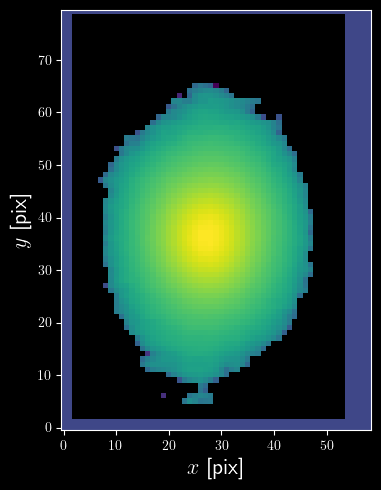

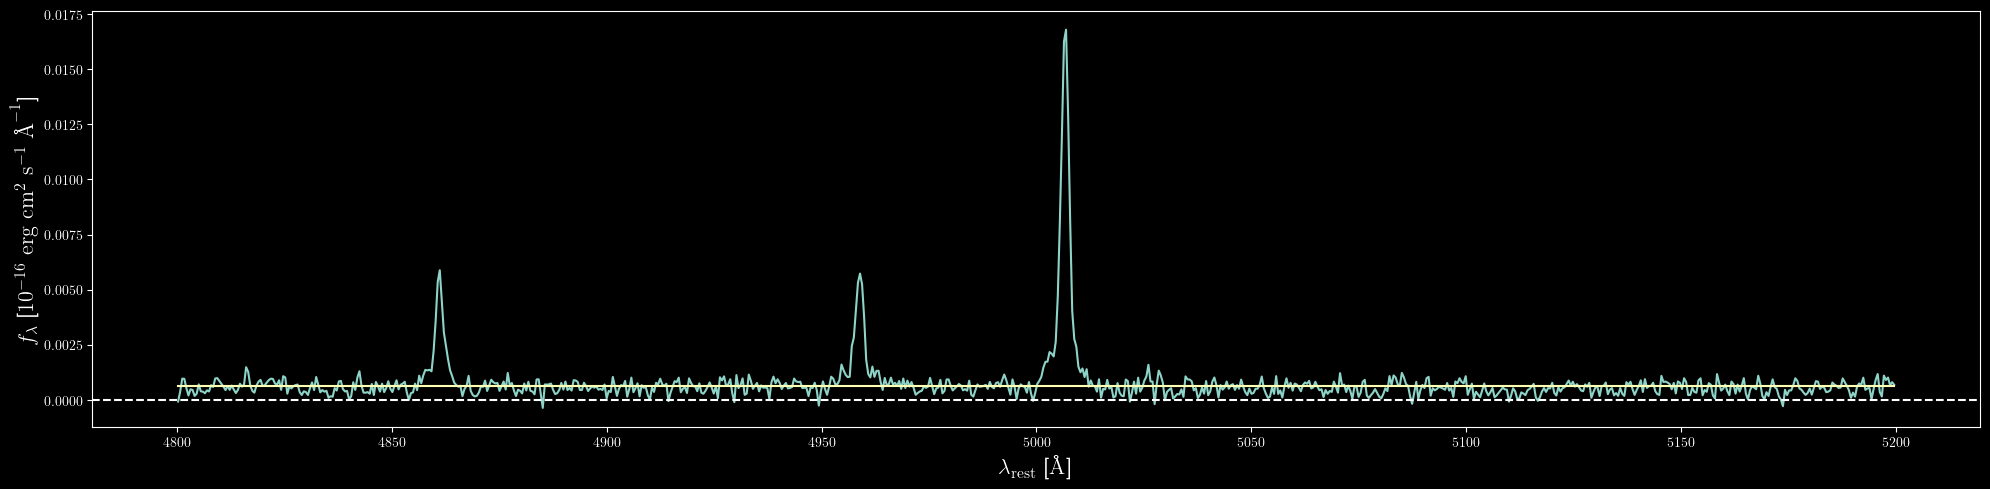

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.stats import median_abs_deviation

cube = spec_loc[0]
print(cube)
# Brightest box
# aperture = [10, 60, 10, 45] # Archana
aperture = [27,30, 37, 40]


hdu = fits.open(spec_loc[0])
# hdu.info()
header = hdu[0].header
# display(header.cards)
nx = header["NAXIS1"]
ny = header["NAXIS2"]
nz = header["NAXIS3"]
print(nx,ny,nz)
z  = 0.042664715 # Redshift from SDSS
ra, dec = 220.719934043, 20.914353010
wave = np.array(header['CRVAL3'] + header['CD3_3']*np.arange(header['NAXIS3']))
mask = np.where((wave>=fit_options["fit_reg"][0]*(1+z)) & (wave<=fit_options["fit_reg"][1]*(1+z)))
wave = wave[mask]
print(hdu[0].data.shape)
# MUSE cubes are normalized by 1.e-20, but BADASS expects it to be normalized by 1.e-17
flux_norm = 1.E-16
print(header["BUNIT"]) # print flux normalization to double check
flux = hdu[0].data[mask]

print(flux.shape) # (nz, ny, nx)
noise = np.full_like(flux,median_abs_deviation(flux))*3.0
var = np.abs(noise)**2
ivar = 1.0/var 
specres =  3600 # spectral resolution R
nz = len(wave)


# Plot the flattened 2D map
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)

flat = np.sum(flux,axis=0)
ax1.imshow(np.log(1000*flat+1)/np.log(1000),
          origin="lower")
ax1.set_ylabel(r"$y$ [pix]",fontsize=16)
ax1.set_xlabel(r"$x$ [pix]",fontsize=16)
plt.tight_layout()

# Plot the flattened spectrum
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)

spec = flux[:,28,38]
noise = noise[:,28,38]

ax1.plot(wave/(1+z),spec)
ax1.plot(wave/(1+z),noise)
ax1.axhline(0.0,color="white",linestyle="--")
ax1.set_ylabel(r"$f_\lambda$ [$10^{-16}~\rm{erg}~\rm{cm}^2~\rm{s}^{-1}~\rm{\AA}^{-1}$]",fontsize=16)
ax1.set_xlabel(r"$\lambda_{\rm{rest}}$ [$\rm{\AA}$]",fontsize=16)
plt.tight_layout()

print(noise)
print(np.median(spec))

### Run

In [5]:
# Unpack the spectra into 1D FITS files
print(f'Unpacking {cube} into subfolders...')
# The formats currently supported are 'muse' and 'manga'
wave,flux,ivar,mask,fwhm_res,binnum,npixels,xpixbin,ypixbin,z,dataid,objname = ifu.prepare_ifu(cube, z, 
                                                                               format='user', 
                                                                               nx=nx,
                                                                               ny=ny,
                                                                               nz=nz,
                                                                               ra=ra,
                                                                               dec=dec,
                                                                               wave=wave,
                                                                               flux=flux,
                                                                               ivar=ivar,
                                                                               specres=specres,
                                                                               aperture=aperture, 
                                                                               targetsn = 3.0 ,
                                                                               snr_threshold = 0.1,
                                                                               voronoi_binning=False,
#                                                                                 maxbins=500,
                                                                              )
# Plot the cube data
ifu.plot_ifu(cube, wave, flux, ivar, mask, binnum, npixels, xpixbin, ypixbin, z, dataid, aperture, objname)
# ifu.plot_ifu(cube, wave, flux, ivar, mask, binnum, npixels, xpixbin, ypixbin, z, dataid, objname)

cube_subdir = os.path.join(os.path.dirname(cube), cube.split(os.sep)[-1].replace('.fits','')) + os.sep
print(cube_subdir)

# sys.exit()

if __name__ == "__main__":

    badass.run_BADASS(cube_subdir,
                     nprocesses       = 4,
                     # nobj             = (0,1750),# Archana
                     nobj             = (0,1),
                     fit_options      = fit_options,
                     mcmc_options     = mcmc_options,
                     comp_options     = comp_options,
                     # New line options
                     narrow_options   = narrow_options,
                     broad_options    = broad_options,
                     absorp_options   = absorp_options,
                     test_options     = test_options,
                     user_lines       = user_lines,
                     user_constraints = user_constraints,
                     combined_lines   = combined_lines,
                     losvd_options    = losvd_options,
                     host_options     = host_options,
                     power_options    = power_options,
                     poly_options     = poly_options,
                     opt_feii_options = opt_feii_options,
                     uv_iron_options  = uv_iron_options,
                     balmer_options   = balmer_options, 
                     plot_options     = plot_options,
                     output_options   = output_options,
                     sdss_spec        = False,
                     ifu_spec         = True,
                     flux_norm = 1.E-16, # Don't forget to give it the flux normalization!
                     )

Unpacking /Users/remington.sexton/BADASS3/example_spectra/KCWI/J1442+2054.fits into subfolders...
/Users/remington.sexton/BADASS3/example_spectra/KCWI/J1442+2054/
Fitting 1 1D spectra
Start process memory: 0.51907789                    
 Storing MCMC_output in /Users/remington.sexton/BADASS3/example_spectra/KCWI/J1442+2054/spaxel_37_27/MCMC_output_5/

 > Starting fit for spaxel_37_27

 Input fitting region exceeds available wavelength range.  BADASS will adjust your fitting range automatically...
		- Input fitting range: (4800, 5200)
		- Available wavelength range: (4800, 5199)
		- New fitting region is (4800, 5200). 



-----------------------------------------------------------
 file:                        spaxel_37_27.fits             
 redshift:                    0.04266                       
 fitting region:              (4800,5200) [A]               
 velocity scale:              28.77 [km/s/pixel]            
 Galactic E(B-V):             0.029                         
 Flux 

## Now we reconstruct the cube data and make some plots!

In [6]:
import importlib
importlib.reload(ifu)

for cube in spec_loc:
    
    _, _, n = ifu.reconstruct_ifu(cube)
    
    # If you want the fit results to be saved as an animated .mp4 file, change animated=True.
    # This option requires that you2 have both the python package ffmpeg and the ffmpeg software itself 
    # installed on your system.  See https://www.ffmpeg.org/download.html for details.
    ifu.plot_reconstructed_cube(os.path.join(os.path.dirname(cube), f'MCMC_output_{n}'), animated=False)

IndexError: list index out of range